In [8]:
# IMPORT REQUIRED LIBRARIES 

import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

print(" All required libraries imported successfully.")


 All required libraries imported successfully.


In [11]:
# LOAD CLEANED DATASET 

# Load the cleaned dataset (make sure the file is in the same folder as this notebook)
df = pd.read_csv("potato_reservoir_cleaned_dataset.csv")

print(" Dataset loaded successfully!")
print(f"Rows: {df.shape[0]} | Columns: {df.shape[1]}")
print("\n Columns:")
print(df.columns.tolist())

display(df.head())

print("\n Missing values per column:")
print(df.isnull().sum())


 Dataset loaded successfully!
Rows: 47114 | Columns: 19

 Columns:
['crop_name', 'apy_item_interval_start', 'state_temperature_max_val', 'state_temperature_min_val', 'state_rainfall_val', 'yield', 'FRL', 'Live Cap FRL', 'Level', 'Current Live Storage', 'state_name_Andhra Pradesh', 'state_name_Chhattisgarh', 'state_name_Jharkhand', 'state_name_Karnataka', 'state_name_Tamil Nadu', 'state_name_Telangana', 'state_name_Uttar Pradesh', 'state_name_Uttarakhand', 'state_name_West Bengal']


,crop_name,apy_item_interval_start,state_temperature_max_val,state_temperature_min_val,state_rainfall_val,yield,FRL,Live Cap FRL,Level,Current Live Storage,state_name_Andhra Pradesh,state_name_Chhattisgarh,state_name_Jharkhand,state_name_Karnataka,state_name_Tamil Nadu,state_name_Telangana,state_name_Uttar Pradesh,state_name_Uttarakhand,state_name_West Bengal
0,potato,0.545455,0.547802,0.624065,0.129277,0.355086,0.436701,0.0,0.183753,0.192105,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,potato,0.545455,0.582967,0.601292,0.027110,0.355086,0.436701,0.0,0.183747,0.191914,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,potato,0.545455,0.605495,0.591094,0.008405,0.355086,0.436701,0.0,0.183744,0.191914,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,potato,0.545455,0.627473,0.618627,0.000000,0.355086,0.436701,0.0,0.183734,0.191642,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,potato,0.545455,0.623077,0.615568,0.000000,0.355086,0.436701,0.0,0.183719,0.191607,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



 Missing values per column:
crop_name                    0
apy_item_interval_start      0
state_temperature_max_val    0
state_temperature_min_val    0
state_rainfall_val           0
yield                        0
FRL                          0
Live Cap FRL                 0
Level                        0
Current Live Storage         0
state_name_Andhra Pradesh    0
state_name_Chhattisgarh      0
state_name_Jharkhand         0
state_name_Karnataka         0
state_name_Tamil Nadu        0
state_name_Telangana         0
state_name_Uttar Pradesh     0
state_name_Uttarakhand       0
state_name_West Bengal       0
dtype: int64


In [12]:
# BUILD SUPERVISED SEQUENCES 

# Define feature columns and target column
feature_cols = [
    "apy_item_interval_start",
    "state_temperature_max_val",
    "state_temperature_min_val",
    "state_rainfall_val",
    "FRL",
    "Live Cap FRL",
    "Level",
    "Current Live Storage",
    "state_name_Andhra Pradesh",
    "state_name_Chhattisgarh",
    "state_name_Jharkhand",
    "state_name_Karnataka",
    "state_name_Tamil Nadu",
    "state_name_Telangana",
    "state_name_Uttar Pradesh",
    "state_name_Uttarakhand",
    "state_name_West Bengal",
]

target_col = "yield"

LOOKBACK = 24   


# Function to build sequences (simple sliding window over time)
def build_sequences(df, feature_cols, target_col, time_col="apy_item_interval_start", lookback=24):
    df_sorted = df.sort_values(time_col).reset_index(drop=True)

    X_list, y_list = [], []

    feature_vals = df_sorted[feature_cols].values
    target_vals = df_sorted[target_col].values

    for i in range(len(df_sorted) - lookback):
        X_window = feature_vals[i : i + lookback]       
        y_target = target_vals[i + lookback]           

        X_list.append(X_window)
        y_list.append(y_target)

    X_seq = np.array(X_list)
    y_seq = np.array(y_list)

    return X_seq, y_seq


# Build sequences
X_seq, y_seq = build_sequences(df, feature_cols, target_col, lookback=LOOKBACK)

print(" Sequence building complete.")
print(f"X_seq shape: {X_seq.shape}")   
print(f"y_seq shape: {y_seq.shape}")   


 Sequence building complete.
X_seq shape: (47090, 24, 17)
y_seq shape: (47090,)


In [13]:
# TRAIN–TEST SPLIT (Random Split) 

from sklearn.model_selection import train_test_split

# Split the sequences into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, shuffle=True
)

print(" Train–Test Split Complete")
print(f"X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"X_test : {X_test.shape}  | y_test : {y_test.shape}")


 Train–Test Split Complete
X_train: (37672, 24, 17) | y_train: (37672,)
X_test : (9418, 24, 17)  | y_test : (9418,)


In [14]:
# BUILD AND TRAIN BiLSTM MODEL 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the BiLSTM model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')   
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print(" BiLSTM training complete.")


Epoch 1/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.0141 - mae: 0.0826 - val_loss: 0.0082 - val_mae: 0.0609 - learning_rate: 0.0010
Epoch 2/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0094 - mae: 0.0658 - val_loss: 0.0071 - val_mae: 0.0540 - learning_rate: 0.0010
Epoch 3/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0082 - mae: 0.0615 - val_loss: 0.0069 - val_mae: 0.0535 - learning_rate: 0.0010
Epoch 4/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0077 - mae: 0.0594 - val_loss: 0.0063 - val_mae: 0.0509 - learning_rate: 0.0010
Epoch 5/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.0074 - mae: 0.0580 - val_loss: 0.0062 - val_mae: 0.0486 - learning_rate: 0.0010
Epoch 6/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.0073 - mae: 0.0574 - val_loss: 0.0060 - val_mae: 0.0480 - learning_rate: 0.0010
Epoch 7/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0070 - mae: 0.0557 - val_loss: 0.0058 - val_mae: 0.0456 - learning_rate:

In [15]:
# EVALUATE BiLSTM MODEL 

y_pred = model.predict(X_test).ravel()

mse  = mean_squared_error(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)

print("\n BiLSTM Evaluation Results")
print(f"MSE  : {mse:.6f}")
print(f"MAE  : {mae:.6f}")
print(f"RMSE : {rmse:.6f}")
print(f"R²   : {r2:.6f}")


295/295 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

 BiLSTM Evaluation Results
MSE  : 0.002124
MAE  : 0.018863
RMSE : 0.046083
R²   : 0.968844


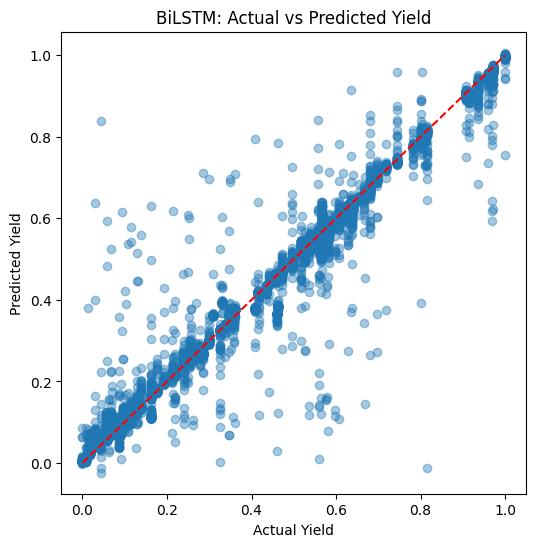

In [16]:
# Scatter plot: Actual vs Predicted

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("BiLSTM: Actual vs Predicted Yield")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()


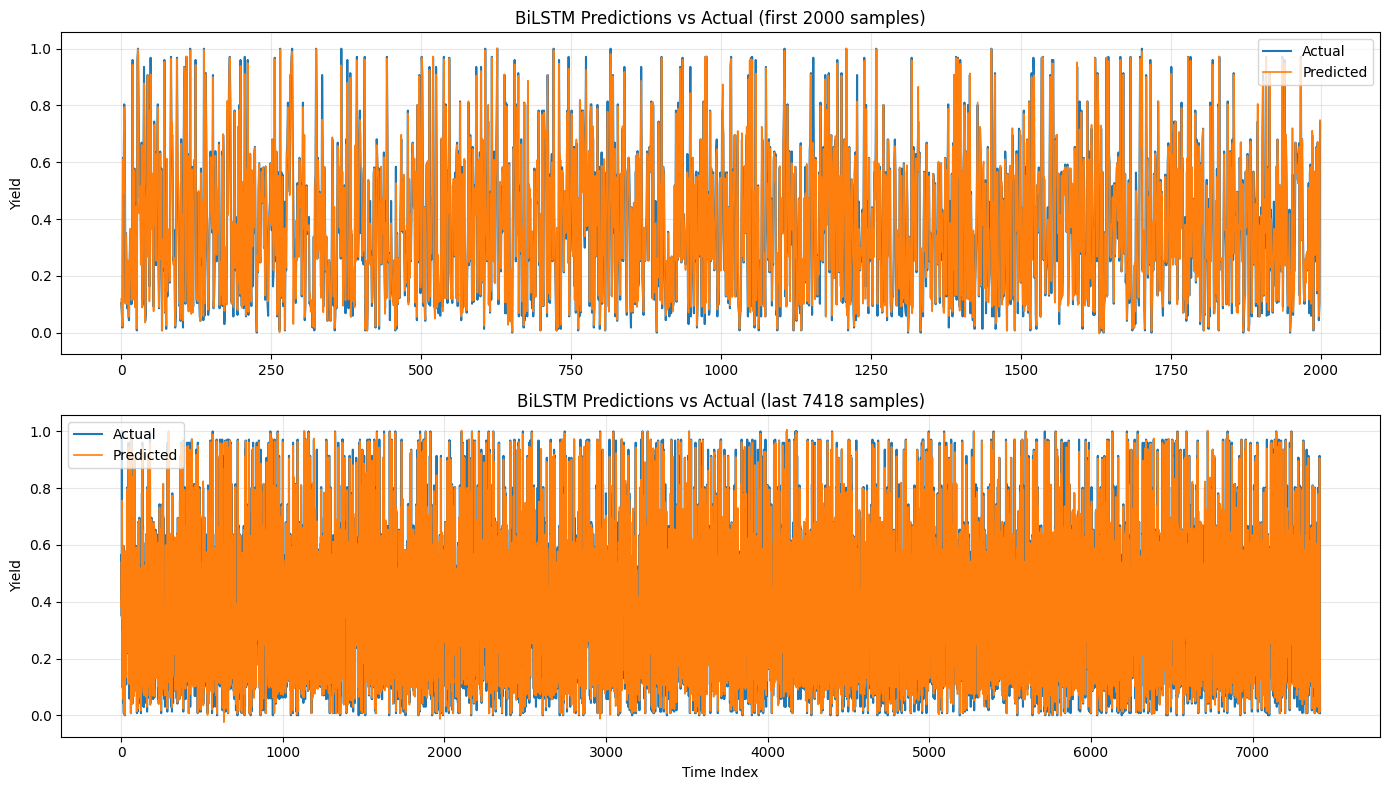

In [17]:
# LINE PLOTS (FIRST 2000 & REMAINING) 

# Make sure y_pred is a flat array
y_pred_flat = y_pred.ravel()
y_test_flat = y_test.ravel()

n_total = len(y_test_flat)
n_first = min(2000, n_total)  
n_last = n_total - n_first       

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharey=True)

# ------- Top plot: first 2000 samples -------
ax1.plot(range(n_first), y_test_flat[:n_first], label="Actual", linewidth=1.5)
ax1.plot(range(n_first), y_pred_flat[:n_first], label="Predicted", linewidth=1.2)
ax1.set_title("BiLSTM Predictions vs Actual (first 2000 samples)")
ax1.set_ylabel("Yield")
ax1.legend()
ax1.grid(True, alpha=0.3)

# ------- Bottom plot: remaining samples -------
ax2.plot(range(n_last), y_test_flat[n_first:], label="Actual", linewidth=1.5)
ax2.plot(range(n_last), y_pred_flat[n_first:], label="Predicted", linewidth=1.2)
ax2.set_title(f"BiLSTM Predictions vs Actual (last {n_last} samples)")
ax2.set_xlabel("Time Index")
ax2.set_ylabel("Yield")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
#--------------CHRONOLOGICAL SPLIT----------------------

In [25]:
# INCLUDE PAST YIELD (LOOKBACK = 24)

import numpy as np

LOOKBACK = 24

# Define base feature columns (excluding 'yield' and 'crop_name')
X_cols_all = [
    "apy_item_interval_start",
    "state_temperature_max_val",
    "state_temperature_min_val",
    "state_rainfall_val",
    "FRL",
    "Live Cap FRL",
    "Level",
    "Current Live Storage",
    "state_name_Andhra Pradesh",
    "state_name_Chhattisgarh",
    "state_name_Jharkhand",
    "state_name_Karnataka",
    "state_name_Tamil Nadu",
    "state_name_Telangana",
    "state_name_Uttar Pradesh",
    "state_name_Uttarakhand",
    "state_name_West Bengal",
]

target_col = "yield"

# We now include past *yield* as an extra feature inside the window
feature_cols_plus = X_cols_all + (["yield"] if "yield" not in X_cols_all else [])


def build_sequences_with_yield(
    df,
    feature_cols,
    target_col="yield",
    time_col="apy_item_interval_start",
    lookback=24,
):

    # sort by time so windows are chronological
    df_sorted = df.sort_values(time_col).reset_index(drop=True)

    X_seq, y_seq = [], []

    feature_values = df_sorted[feature_cols].values
    target_values = df_sorted[target_col].values

    for t in range(lookback, len(df_sorted)):
        # window [t-lookback ... t-1] → contains past yields & features
        X_window = feature_values[t - lookback : t, :]
        y_target = target_values[t]  # yield at time t

        X_seq.append(X_window)
        y_seq.append(y_target)

    X_seq = np.asarray(X_seq, dtype=np.float32)
    y_seq = np.asarray(y_seq, dtype=np.float32)

    return X_seq, y_seq


X_seq_v2, y_seq_v2 = build_sequences_with_yield(
    df,
    feature_cols=feature_cols_plus,
    target_col=target_col,
    lookback=LOOKBACK,
)

print(" Sequences rebuilt with past yield (V2-style).")
print("X_seq_v2:", X_seq_v2.shape, "(samples, lookback, features)")
print("y_seq_v2:", y_seq_v2.shape)


 Sequences rebuilt with past yield (V2-style).
X_seq_v2: (47090, 24, 18) (samples, lookback, features)
y_seq_v2: (47090,)


In [26]:
# TRAIN–TEST SPLIT (Chronological Split)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_seq_v2,
    y_seq_v2,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)

print(" V2 sequence split complete.")
print("X_train:", X_train.shape, "| y_train:", y_train.shape)
print("X_test :", X_test.shape,  "| y_test :", y_test.shape)


 V2 sequence split complete.
X_train: (37672, 24, 18) | y_train: (37672,)
X_test : (9418, 24, 18) | y_test : (9418,)


In [27]:
# BiLSTM MODEL 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

print(" BiLSTM training started...")

model_lstm = Sequential([
    Bidirectional(
        LSTM(64, return_sequences=True),
        input_shape=(X_train.shape[1], X_train.shape[2])
    ),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1, activation="linear"),
])

model_lstm.compile(optimizer="adam", loss="mse")

es = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5, verbose=1)

history = model_lstm.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=60,
    batch_size=64,
    verbose=1,
    callbacks=[es, rlr],
)

print(" BiLSTM training completed!")


 BiLSTM training started...
Epoch 1/60
530/530 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0076 - val_loss: 0.0057 - learning_rate: 0.0010
Epoch 2/60
530/530 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0038 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 3/60
530/530 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0033 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 4/60
530/530 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0030 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 5/60
528/530 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0028
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
530/530 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0028 - val_loss: 0.0063 - learning_rate: 0.0010
Epoch 6/60
530/530 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0027 - val_loss: 0.0056 - learning_rate: 5.0000e-04
Epoch 7/60
530/530 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0026 - val_loss: 0.0047 - learning_rate: 5.0000e-04
Epoch 8/60
529/530 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step -

In [33]:
# EVALUATION  

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred_bilstm = model_lstm.predict(X_test, verbose=0).ravel()

mse_bilstm = mean_squared_error(y_test, y_pred_bilstm)
mae_bilstm = mean_absolute_error(y_test, y_pred_bilstm)
rmse_bilstm = np.sqrt(mse_bilstm)
r2_bilstm = r2_score(y_test, y_pred_bilstm)

print("\n BiLSTM Results")
print(f"MSE  : {mse_bilstm:.6f}")
print(f"MAE  : {mae_bilstm:.6f}")
print(f"RMSE : {rmse_bilstm:.6f}")
print(f"R²   : {r2_bilstm:.6f}")



 BiLSTM Results
MSE  : 0.003358
MAE  : 0.037120
RMSE : 0.057952
R²   : 0.950730


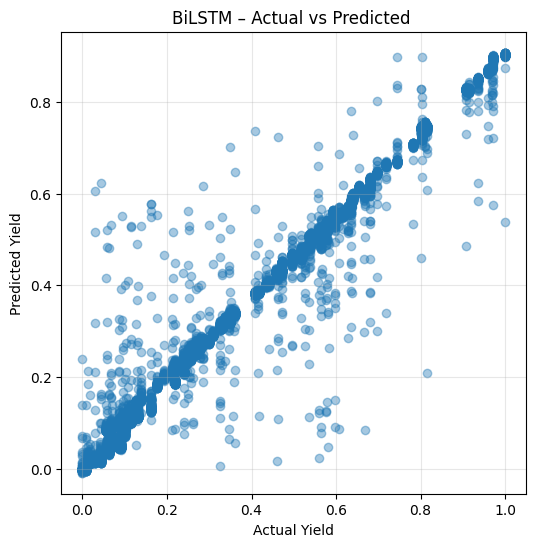

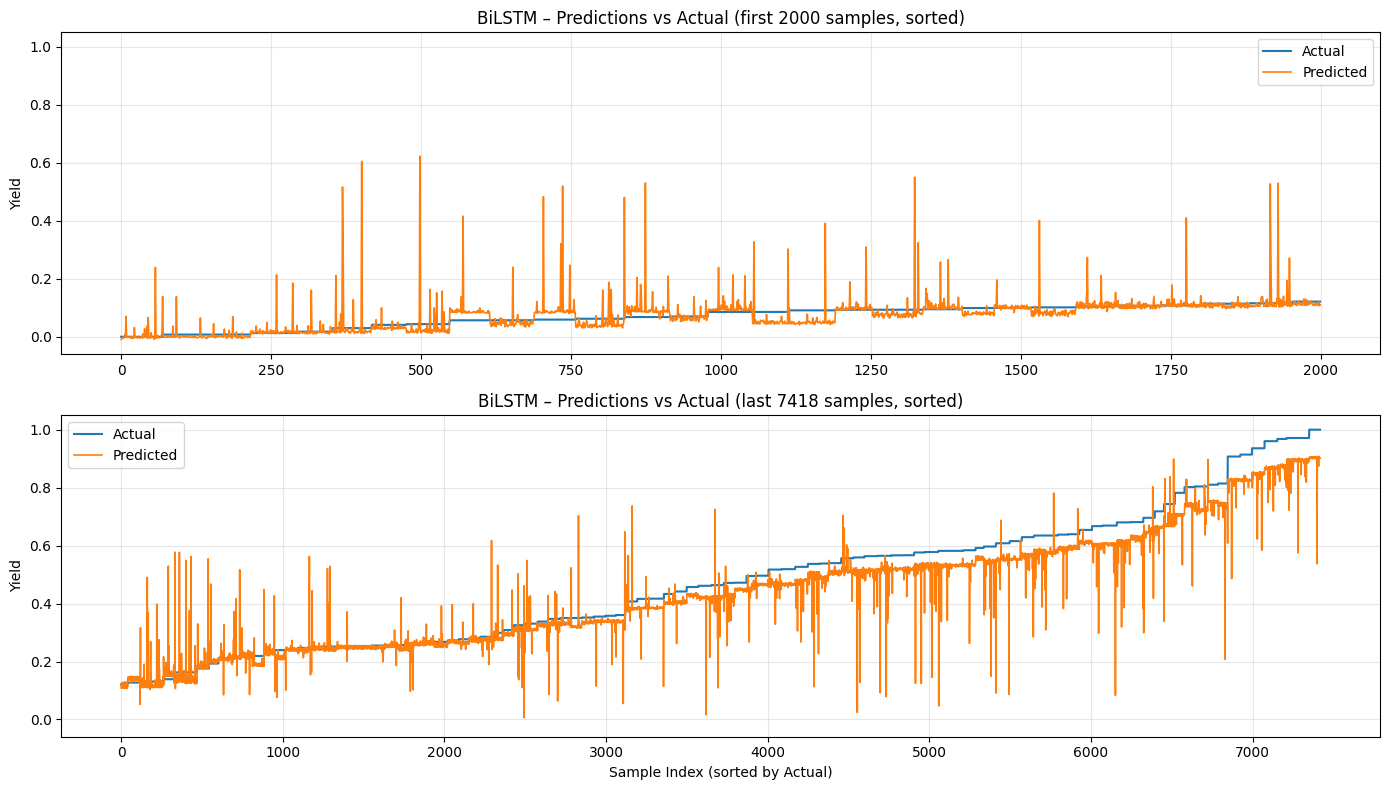

In [32]:
# PLOTS

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

y_true = y_test.ravel()
y_pred = y_pred_bilstm.ravel()

plot_df = pd.DataFrame({
    "Actual": y_true,
    "Predicted": y_pred
}).sort_values("Actual").reset_index(drop=True)

n_total = len(plot_df)
n_first = min(2000, n_total)
n_last = n_total - n_first

# ---------- 1) Scatter: Actual vs Predicted ----------
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.4)
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("BiLSTM – Actual vs Predicted ")
plt.grid(True, alpha=0.3)
plt.show()

# ---------- 2) Line plots: first 2000 & last N ----------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharey=True)

# Top: first 2000 (or fewer) samples
ax1.plot(range(n_first), plot_df["Actual"][:n_first], label="Actual", linewidth=1.5)
ax1.plot(range(n_first), plot_df["Predicted"][:n_first], label="Predicted", linewidth=1.2)
ax1.set_title(f"BiLSTM – Predictions vs Actual (first {n_first} samples, sorted)")
ax1.set_ylabel("Yield")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bottom: remaining samples
if n_last > 0:
    ax2.plot(range(n_last), plot_df["Actual"][n_first:], label="Actual", linewidth=1.5)
    ax2.plot(range(n_last), plot_df["Predicted"][n_first:], label="Predicted", linewidth=1.2)
    ax2.set_title(f"BiLSTM – Predictions vs Actual (last {n_last} samples, sorted)")
    ax2.set_xlabel("Sample Index (sorted by Actual)")
    ax2.set_ylabel("Yield")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
